#### 猫-狗分类网络改进：使用预学习网络

**图像数据导入为dataset**

In [1]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dir = 'cats_and_dogs_small/train'
validation_dir = 'cats_and_dogs_small/validation'
test_dir = 'cats_and_dogs_small/test'

train_dataset = image_dataset_from_directory(train_dir,labels='inferred',image_size=(150,150),batch_size=20,label_mode='binary')
validation_dataset = image_dataset_from_directory(validation_dir,labels='inferred',image_size=(150,150),batch_size=20,label_mode='binary')
test_dataset = image_dataset_from_directory(test_dir,labels='inferred',image_size=(150,150),batch_size=20,label_mode='binary')

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


**构建数据增广网络**

In [2]:
from tensorflow.keras import layers
from tensorflow.keras import models

data_augmentation = models.Sequential(name='Data_Augmentation')
data_augmentation.add(layers.Input(shape=(150,150,3)))
data_augmentation.add(layers.RandomRotation(factor=(-0.12,+0.12)))
data_augmentation.add(layers.RandomFlip(mode='horizontal'))
data_augmentation.add(layers.RandomZoom(height_factor=(-0.2, 0.2)))

data_augmentation.summary()

Model: "Data_Augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 150, 150, 3)      0         
 tion)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 150, 150, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


**导入预学习网络**
+ 导入VGG16网络
+ 使用在ImageNet数据集上预学习的参数
+ 不包含原网络的分类部分，仅保留卷积部分
+ 输入层设定为：$150\times150\times3$

In [3]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

**构建网络**

+ 加入输入层和预处理网络
+ 加入VGG16预学习网络，将所有卷积核的参数设置为不可学习
+ 增加全连接层：256个神经元
+ 增加输出层：1个神经元，激活函数sigmoid

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers

conv_base.trainable = False

network = models.Sequential()
network.add(layers.Input(shape=(150,150,3)))
network.add(data_augmentation)
network.add(conv_base)
network.add(layers.Flatten())
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dense(1, activation='sigmoid'))

network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Data_Augmentation (Sequenti  (None, 150, 150, 3)      0         
 al)                                                             
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
____________________________________

**学习网络**
+ 优化算法：RMSprop，学习率$0.00002$
+ 损失函数：binary_crossentropy
+ 以分类正确率作为度量指标
+ 学习30个回合，每个回合迭代100个batch，每个batch为20个训练样本
+ 学习样本为训练集dataset
+ 验证集dataset仅作为观察数据，每20次迭代观察一次

In [5]:
from tensorflow.keras import optimizers

network.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(learning_rate=2e-5),metrics=['acc'])
history = network.fit(train_dataset,steps_per_epoch=100,epochs=30,validation_data=validation_dataset,validation_steps=20)

Epoch 1/30
100/100 [==============================] - 17s 124ms/step - loss: 2.3006 - acc: 0.7555 - val_loss: 1.1396 - val_acc: 0.8925
Epoch 2/30
100/100 [==============================] - 13s 126ms/step - loss: 1.2563 - acc: 0.8405 - val_loss: 0.9642 - val_acc: 0.9175
Epoch 3/30
100/100 [==============================] - 13s 127ms/step - loss: 0.8649 - acc: 0.8720 - val_loss: 0.8281 - val_acc: 0.9275
Epoch 4/30
100/100 [==============================] - 13s 126ms/step - loss: 0.7869 - acc: 0.8955 - val_loss: 0.9573 - val_acc: 0.9175
Epoch 5/30
100/100 [==============================] - 12s 124ms/step - loss: 0.6668 - acc: 0.9000 - val_loss: 0.5693 - val_acc: 0.9350
Epoch 6/30
100/100 [==============================] - 12s 124ms/step - loss: 0.7066 - acc: 0.9025 - val_loss: 0.7707 - val_acc: 0.9225
Epoch 7/30
100/100 [==============================] - 12s 125ms/step - loss: 0.5975 - acc: 0.9120 - val_loss: 0.7121 - val_acc: 0.9300
Epoch 8/30
100/100 [==============================] - 1

**测试网络**
+ 分别使用训练集、验证集和测试集评估网络的性能

In [6]:
train_loss, train_acc = network.evaluate(train_dataset)
validation_loss, validation_acc = network.evaluate(validation_dataset)
test_loss, test_acc = network.evaluate(test_dataset)

print('\nTrain Accuracy:     ', train_acc)
print('Validation Accuracy:', validation_acc)
print('Test Accuracy:      ', test_acc)

50/50 [==============================] - 5s 96ms/step - loss: 0.5998 - acc: 0.9420

Train Accuracy:      0.9909999966621399
Validation Accuracy: 0.9350000023841858
Test Accuracy:       0.9419999718666077


**显示学习过程**

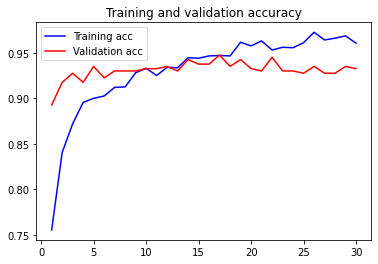

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()